The basic goal of speech processing is to provide an interaction between a human and a machine.

Speech processing system has mainly three tasks −

    First, speech recognition that allows the machine to catch the words, phrases and sentences we speak

    Second, natural language processing to allow the machine to understand what we speak

    Third, speech synthesis to allow the machine to speak.


The first component of speech recognition is, of course, speech. Speech must be converted from physical sound to an
electrical signal with a microphone, and then to digital data with an analog-to-digital converter. Once digitized, several models can be used to transcribe the audio to text.

Most modern speech recognition systems rely on what is known as a Hidden Markov Model (HMM). This approach works
on the assumption that a speech signal, when viewed on a short enough timescale (say, ten milliseconds), can be
reasonably approximated as a stationary process—that is, a process in which statistical properties do not change over
time.

In a typical HMM, the speech signal is divided into 10-millisecond fragments. The power spectrum of each fragment,
which is essentially a plot of the signal’s power as a function of frequency, is mapped to a vector of real numbers known
as cepstral coefficients. The dimension of this vector is usually small—sometimes as low as 10, although more accurate
systems may have dimension 32 or more. The final output of the HMM is a sequence of these vectors.


To decode the speech into text, groups of vectors are matched to one or more phonemes—a fundamental unit of speech.
This calculation requires training, since the sound of a phoneme varies from speaker to speaker, and even varies from
one utterance to another by the same speaker. A special algorithm is then applied to determine the most likely word (or
words) that produce the given sequence of phonemes.


One can imagine that this whole process may be computationally expensive. In many modern speech recognition
systems, neural networks are used to simplify the speech signal using techniques for feature transformation and
dimensionality reduction before HMM recognition. Voice activity detectors (VADs) are also used to reduce an audio signal to only the portions that are likely to contain speech. This prevents the recognizer from wasting time analyzing
unnecessary parts of the signal.

# Visualizing Audio Signals - Reading from a File and Working on it


When recording with microphone, the signals are stored in a digitized form. But to work upon it, the machine needs them in the discrete numeric form. Hence, we should perform sampling at a certain frequency and convert the signal into the discrete numerical form. Choosing the high frequency for sampling implies that when humans listen to the signal, they feel it as a continuous audio signal.
Example

The following example shows a stepwise approach to analyze an audio signal, using Python, which is stored in a file.

In [296]:
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
#import librosa #is a Python package for music and audio processing by Brian McFee
#import librosa.display
import IPython.display as ipds
#pip install python_speech_features
from python_speech_features import mfcc,logfbank

Now, read the stored audio file. It will return two values: the sampling frequency and the audio signal. Provide the path of the audio file where it is stored, as shown here −

In [297]:
path='sound.wav'

In [236]:
frequency_sampling, audio_signal =wavfile.read(path)

In [237]:
ipds.Audio(path)

This step involves normalizing the signal as shown below −

In [191]:
audio_signal=audio_signal/np.power(2,15)

In this step, we are extracting all values from this signal to visualize. Use the following commands for this purpose

In [240]:
signal=audio_signal#[:2000]
time_ax=1000*np.arange(0,len(signal),1)/float(frequency_sampling)

Now, visualize the signal using the commands given below −

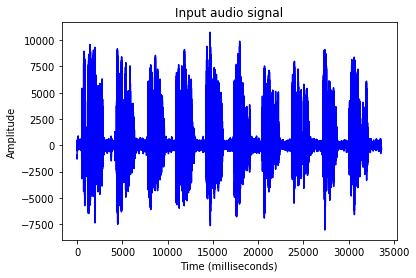

In [241]:
plt.plot(time_ax,signal,color='blue')
plt.xlabel('Time (milliseconds)')
plt.ylabel('Amplitude')
plt.title('Input audio signal')
plt.show()


In [245]:
print('\n Signal shape',audio_signal.shape)
print('\n Signal Data type',audio_signal.dtype)
print('\n Signal duration',round(signal.shape[0]/float(frequency_sampling),2),'seconds')
print('\n frequency sampling:',frequency_sampling)


 Signal shape (268985,)

 Signal Data type int16

 Signal duration 33.62 seconds

 frequency sampling: 8000


# Characterizing the Audio Signal

If I sent this voltage to a speaker, I might hear words but I can’t very well imagine how it would sound in my head. Is there a better way of seeing what is going on?

There is, and it is called the discrete Fourier transform, or DFT, where discrete refers to the recording consisting of time-spaced sound measurements, in contrast to a continual recording as, for example, on magnetic tape (remember cassettes?). The DFT is often computed using the FFT algorithm, a name informally used to refer to the DFT itself. The DFT tells us which frequencies or “notes” to expect in our signal.

The Fourier transform takes a signal in the time domain (i.e., a set of measurements over time) and turns it into a spectrum—a set of frequencies with corresponding (complex2) values. The spectrum does not contain any information about time!
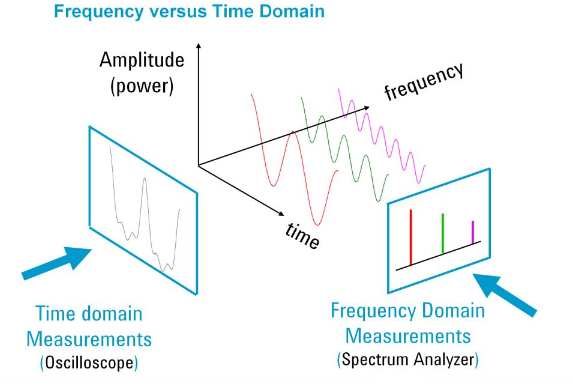

to find both the frequencies and the time  we’ll need to be somewhat clever. Our strategy is as follows: take the audio signal, split it into small, overlapping slices, and apply the Fourier transform to each (a technique known as the short time Fourier transform). We’ll split the signal into slices of 1,024 samples—that’s about 0.03 seconds of audio.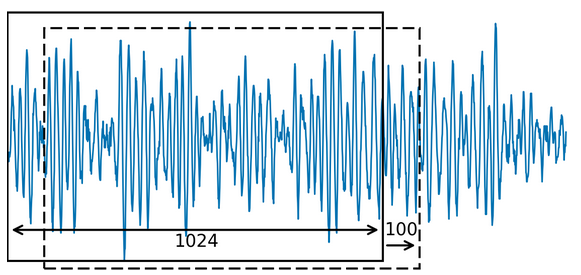

Start by chopping up the signal into slices of 1024 samples, each slice overlapping the previous by 100 samples. The resulting slices object contains one slice per row.

In [246]:
from skimage import util
M=1024
slices=util.view_as_windows(audio_signal,step=100,window_shape=(M,))

In [247]:
print('\n Signal shape',audio_signal.shape)
print('\n Slice shape',slices.shape)



 Signal shape (268985,)

 Slice shape (2680, 1024)


Generate a windowing function (see “Windowing” for a discussion of the underlying assumptions and interpretations of each) and multiply it with the signal:

In [250]:
win=np.hanning(M+1)[:-1]
slices=slices*win

It’s more convenient to have one slice per column, so we take the transpose:

In [251]:
slices = slices.T
print('Shape of `slices`:', slices.shape)

Shape of `slices`: (1024, 2680)


For each slice, calculate the DFT, which returns both positive and negative frequencies (more on that in “Frequencies and Their Ordering”), so we slice out the positive M2 frequencies for now.

In [256]:
spectrum = np.fft.fft(slices, axis=0)[:M // 2 + 1:-1]
spectrum = np.abs(spectrum)

The spectrum can contain both very large and very small values. Taking the log compresses the range significantly.

Here we do a log plot of the ratio of the signal divided by the maximum signal (shown in below Figure). The specific unit used for the ratio is the decibel, 20log10 (amplitude ratio).

Text(0.5, 0, 'Time [s]')

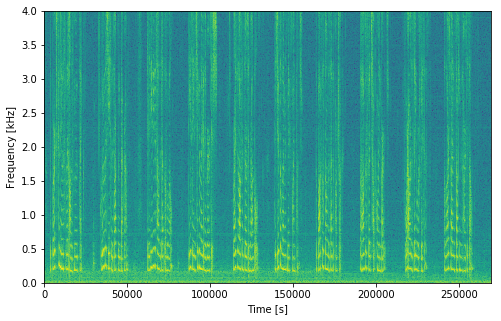

In [258]:
f, ax = plt.subplots(figsize=(8,5))

S = np.abs(spectrum)
S = 20 * np.log10(S / np.max(S))

ax.imshow(S, origin='lower', cmap='viridis',
          extent=(0, len(audio_signal), 0, frequency_sampling / 2 / 1000))
ax.axis('tight')
ax.set_ylabel('Frequency [kHz]')
ax.set_xlabel('Time [s]')

SciPy already includes an implementation of this procedure as scipy.signal.spectrogram (Figure below), which can be invoked as follows:

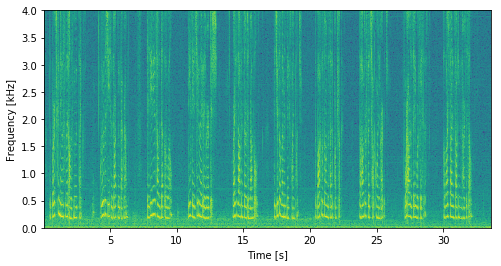

In [259]:
from scipy import signal
freq,time,Sx=signal.spectrogram(audio_signal,fs=frequency_sampling,window='hanning',
                                nperseg=1024,noverlap=M-100,detrend=False,scaling='spectrum')
f,ax=plt.subplots(figsize=(8,4))
ax.pcolormesh(time,freq/1000,10*np.log10(Sx),cmap='viridis')
ax.set_ylabel('Frequency [kHz]')
ax.set_xlabel('Time [s]');

The only differences between the manual spectrogram that we created versus the SciPy’s built-in function are that SciPy returns the spectrum magnitude squared (which turns measured voltage into measured energy), and multiplies it by some normalization factors.4

##### The DFT functionality in SciPy lives in the scipy.fftpack module. Among other things, it provides the following DFT-related functionality:

        fft, fft2, fftn

            Compute the DFT using the FFT algorithm in 1, 2, or n dimensions.
        ifft, ifft2, ifftn

            Compute the inverse of the DFT.
        dct, idct, dst, idst

            Compute the cosine and sine transforms, and their inverses.
        fftshift, ifftshift

            Shift the zero-frequency component to the center of the spectrum and back, respectively (more about that soon).
        fftfreq

            Return the DFT sample frequencies.
        rfft

            Compute the DFT of a real sequence, exploiting the symmetry of the resulting spectrum for increased performance. Also used by fft internally when applicable.

This list is complemented by the following functions in NumPy:

    np.hanning, np.hamming, np.bartlett, np.blackman, np.kaiser

    Tapered windowing functions.

The DFT is also used to perform fast convolutions of large inputs by scipy.signal.fftconvolve.

SciPy wraps the Fortran FFTPACK library—it is not the fastest out there, but unlike packages such as FFTW, it has a permissive free software license.

# Transforming to Frequency Domain

Characterizing an audio signal involves converting the time domain signal into frequency domain, and understanding its frequency components, by. This is an important step because it gives a lot of information about the signal. We can use a mathematical tool like Fourier Transform to perform this transformation

Now, we need to apply mathematics tools for transforming into frequency domain. Here we are using the Fourier Transform.
more information :https://makersportal.com/blog/2018/9/13/audio-processing-in-python-part-i-sampling-and-the-fast-fourier-transform

In [260]:
signal_frequency=np.fft.fft(audio_signal)

This step involves extracting the length and half length of the signal. Use the following commands for this purpose −

In [261]:
length_signal=len(audio_signal)
half_length=np.ceil((length_signal+1)/2.0).astype(np.int)

Now, do the normalization of frequency domain signal and square it −

In [262]:
signal_frequency=abs(signal_frequency[0:half_length])/length_signal
signal_frequency **=2

Next, extract the length and half length of the frequency transformed signal −

In [263]:
len_fts = len(signal_frequency)

Note that the Fourier transformed signal must be adjusted for even as well as odd case.

In [264]:
if length_signal % 2:
   signal_frequency[1:len_fts] *= 2
else:
   signal_frequency[1:len_fts-1] *= 2

Now, extract the power in decibal(dB) −

In [265]:
signal_power = 10 * np.log10(signal_frequency)

Adjust the frequency in kHz for X-axis −

In [266]:
x_axis = np.arange(0, half_length, 1) * (frequency_sampling / length_signal) / 1000.0

Now, visualize the characterization of signal as follows −

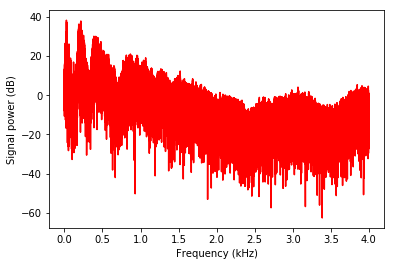

In [267]:
plt.figure()
plt.plot(x_axis, signal_power, color='red')
plt.xlabel('Frequency (kHz)')
plt.ylabel('Signal power (dB)')
plt.show()

# Feature Extraction from Speech

This is the most important step in building a speech recognizer because after converting the speech signal into the frequency domain, we must convert it into the usable form of feature vector. We can use different feature extraction techniques like MFCC, PLP, PLP-RASTA etc. for this purpose.

In [293]:
audio_signal_block=audio_signal[:5000]

Use the MFCC techniques and execute the following command to extract the MFCC features −

In [294]:
features_mfcc=mfcc(audio_signal_block,frequency_sampling)

In [295]:
print('\n Number of Windows:',features_mfcc.shape[0])
print('\n Length of features',features_mfcc.shape[1])


 Number of Windows: 61

 Length of features 13


Now, plot and visualize the MFCC features using the commands given below −

Text(0.5, 1.05, 'MFCC')

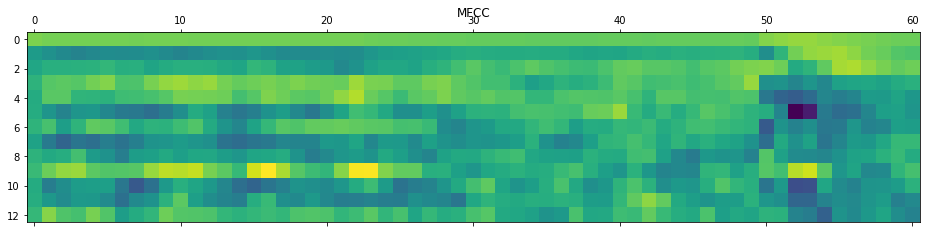

In [271]:
features_mfcc=features_mfcc.T
plt.matshow(features_mfcc)
plt.title('MFCC')

In this step, we work with the filter bank features as shown − Extract the filter bank features 

In [272]:
filter_bank_features=logfbank(audio_signal_block,frequency_sampling)

In [273]:
print('\n Number of Windows:',filter_bank_features.shape[0])
print('\n Length of features',filter_bank_features.shape[1])


 Number of Windows: 61

 Length of features 26


Text(0.5, 1.05, 'Filter bank')

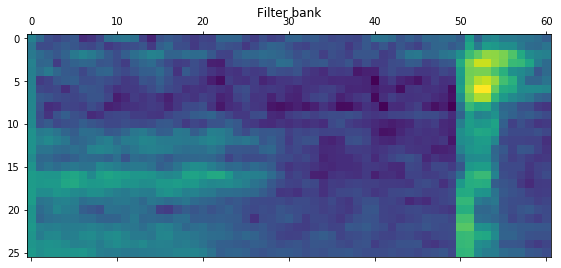

In [274]:
features_mfcc=filter_bank_features.T
plt.matshow(features_mfcc)
plt.title('Filter bank')

# Speech Recognition Packages
A handful of packages for speech recognition exist on PyPI. A few of them include:

    piai
    assemblyai
    google-cloud-speech
    pocketsphinx
    SpeechRecognition
    watson-developer-cloud
    wit

Some of these packages—such as wit and apiai—offer built-in features, like natural language processing for identifying a
speaker’s intent, which go beyond basic speech recognition. Others, like google-cloud-speech, focus solely on speechto-
text conversion.

# Installing SpeechRecognition

SpeechRecognition is compatible with Python 2.6, 2.7 and 3.3+,
To install you can use : 

    pip install SpeechRecognition
    
Notably, the PyAudio package is needed for capturing microphone input.

In [275]:
import speech_recognition as sr

In [276]:
print(sr.__version__)

3.8.1


# The Recognizer Class

All of the magic in SpeechRecognition happens with the Recognizer class.
The primary purpose of a Recognizer instance is, of course, to recognize speech. Each instance comes with a variety of
settings and functionality for recognizing speech from an audio source.
Creating a Recognizer instance is easy. In your current interpreter session

In [277]:
r=sr.Recognizer()

Each Recognizer instance has seven methods for recognizing speech from an audio source using various APIs. These
are:

            recognize_bing(): Microsoft Bing Speech
            recognize_google(): Google Web Speech API
            recognize_google_cloud(): Google Cloud Speech - requires installation of the google-cloud-speech package
            recognize_houndify(): Houndify by SoundHound
            recognize_ibm(): IBM Speech to Text
            recognize_sphinx(): CMU Sphinx - requires installing PocketSphinx
            recognize_wit(): Wit.ai

Of the seven, only recognize_sphinx() works offline with the CMU Sphinx engine. The other six all require an internet
connection.

A full discussion of the features and benefits of each API is beyond the scope of this tutorial. Since SpeechRecognition
ships with a default API key for the Google Web Speech API, you can get started with it right away. For this reason, we’ll
use the Web Speech API in this guide. The other six APIs all require authentication with either an API key or a
username/password combination. For more information, consult the SpeechRecognition docs.

Before you continue, you’ll need to download an audio file. The one I used to get started, “harvard.wav,” can be found
here. Make sure you save it to the same directory in which your Python interpreter session is running.

In [278]:
harvard=sr.AudioFile('sound.wav')
with harvard as source:
    audio=r.record(source)

The context manager opens the file and reads its contents, storing the data in an AudioFile instance called source.
Then the record() method records the data from the entire file into an AudioData instance. You can confirm this by
checking the type of audio:

In [279]:
type(audio)

speech_recognition.AudioData

You can now invoke recognize_google() to attempt to recognize any speech in the audio. Depending on your internet
connection speed, you may have to wait several seconds before seeing the result.

In [280]:
r.recognize_google(audio)

'the Birch canoe slid on the smooth planks glue the seat to the dark blue background it is easy to tell the depth of a well these days a chicken leg is a verb dish rice is often served in round Bowls the juice of lemons makes fine punch the box was the one beside the pump truck the Hogs are such hot corn and garbage 4 hours of study works'

# Capturing Segments With offset and duration
What if you only want to capture a portion of the speech in a file? The record() method accepts a duration keyword
argument that stops the recording after a specified number of seconds.
For example, the following captures any speech in the first four seconds of the file:

In [281]:
with harvard as source:
    audio=r.record(source,duration=4)
r.recognize_google(audio)

'the Birch canoe slid on the smooth planks'

The record() method, when used inside a with block, always moves ahead in the file stream. This means that if you
record once for four seconds and then record again for four seconds, the second time returns the four seconds of audio
after the first four seconds.

In [282]:
with harvard as source:
    audio1=r.record(source,duration=4)
    audio2=r.record(source,duration=4)
print(r.recognize_google(audio1))
print(r.recognize_google(audio2))

the Birch canoe slid on the smooth planks
glue the sheet to the dark blue background


When specifying a duration, the recording might stop
mid-phrase—or even mid-word—which can hurt the accuracy of the transcription.

In addition to specifying a recording duration, the record() method can be given a specific starting point using the
offset keyword argument. This value represents the number of seconds from the beginning of the file to ignore before
starting to record.

In [283]:
with harvard as source:
    audio=r.record(source,offset=3,duration=4)
print(r.recognize_google(audio))

Flex glue the seat to a dark blue back


The offset and duration keyword arguments are useful for segmenting an audio file if you have prior knowledge of the
structure of the speech in the file. However, using them hastily can result in poor transcriptions.
There is another reason you may get inaccurate transcriptions. Noise!

# The Effect of Noise on Speech Recognition

Noise is a fact of life. All audio recordings have some degree of noise in them, and un-handled noise can wreck the
accuracy of speech recognition apps

So how do you deal with noise? One thing you can try is using the adjust_for_ambient_noise() method of the
Recognizer class.

In [284]:
with harvard as source:
    r.adjust_for_ambient_noise(source)
    audio=r.record(source)
print(r.recognize_google(audio))

Birch canoe slid on the smooth planks glue the seat to the dark blue background it is easy to tell the depth of a well these day the chicken leg is a verb dish rice is often served in Braunfels the juice of lemons makes fine punch the box was the one beside the park truck the Hogs are such hot corn and garbage 4 hours of study works


The adjust_for_ambient_noise() method reads the first second of the file stream and calibrates the recognizer to the
noise level of the audio. Hence, that portion of the stream is consumed before you call record() to capture the data.
You can adjust the time-frame that adjust_for_ambient_noise() uses for analysis with the duration keyword
argument. This argument takes a numerical value in seconds and is set to 1 by default. Try lowering this value to 0.5.

In [285]:
with harvard as source:
    r.adjust_for_ambient_noise(source,duration=.5)
    audio=r.record(source)
print(r.recognize_google(audio))

the Birch canoe slid on the smooth planks glue the seat to the dark blue background it is easy to tell the depth of a well these days a chicken leg is a verb dish rice is often served in round Bowls the juice of lemons makes fine punch the box was the one beside the pump truck the Hogs are such hot corn and garbage 4 hours of study works


Well, that got you “the” at the beginning of the phrase

If you find yourself running up against these issues frequently, you may have to resort to some pre-processing of the
audio. This can be done with audio editing software or a Python package (such as SciPy) that can apply filters to the files.,
check out Allen Downey’s Think DSP book if you are
interested.
https://greenteapress.com/wp/think-dsp/


# Working With Microphones
To access your microphone with SpeechRecognizer, you’ll have to install the PyAudio package.
The process for installing PyAudio will vary depending on your operating system.

Windows

        pip install pyaudio
Debian Linux

        sudo apt-get install python-pyaudio python3-pyaudio

Now, instead of using an audio file as the source, you will use the default system microphone. You can access this by
creating an instance of the Microphone class.

In [286]:
mic=sr.Microphone()

If your system has no default microphone (such as on a RaspberryPi), or you want to use a microphone other than the
default, you will need to specify which one to use by supplying a device index. You can get a list of microphone names by
calling the list_microphone_names() static method of the Microphone class.

In [287]:
print(sr.Microphone.list_microphone_names())

['Microsoft Soundmapper - Input', 'Mikrofonarray (Realtek High Def', 'Microsoft Soundmapper - Output', 'Lautsprecher/Kopfhörer (Realtek', 'BenQ GL2460 (Intel(R) Display-A']


Note that your output may differ from the above example.

In [288]:
mic=sr.Microphone(device_index=1)

# Using listen() to Capture Microphone Input

You can capture input from the microphone using the
listen() method of the Recognizer class inside of the with block. This method takes an audio source as its first
argument and records input from the source until silence is detected.

Once you execute the with block, try speaking “hello” into your microphone. Wait a moment for the interpreter prompt
to display again. Once the “>>>” prompt returns, you’re ready to recognize the speech.

In [291]:
with mic as source:
    audio=r.listen(source)
print(r.recognize_google(audio))

hello my name is Amira


To handle ambient noise, you’ll need to use the adjust_for_ambient_noise() method of the Recognizer class, just like
you did when trying to make sense of the noisy audio file. Since input from a microphone is far less predictable than
input from an audio file, it is a good idea to do this anytime you listen for microphone input.

In [292]:
with mic as source:
    r.adjust_for_ambient_noise(source, duration=.4)
    audio=r.listen(source)
print(r.recognize_google(audio))

I'm from Canada


After running the above code, wait .4 milisecond for adjust_for_ambient_noise() to do its thing, then try speaking “hello”
into the microphone. Again, you will have to wait a moment for the interpreter prompt to return before trying to
recognize the speech.

In [ ]:
https://www.oreilly.com/library/view/elegant-scipy/9781491922927/ch04.html
http://myinspirationinformation.com/uncategorized/audio-signals-in-python/
https://www.tutorialspoint.com/artificial_intelligence_with_python/artificial_intelligence_with_python_speech_recognition
https://musicinformationretrieval.com/ipython_audio.html
https://realpython.com/python-speech-recognition/